# Project Assignment DLTA
----------------------

## Team information

|Team-number :| 1|
|:----:|:----:|


|Name|    E-Mail        |matriculation-nr.|
|:----:|:----:|:----:|
|Student 1| Student1@uni-passau.de|1234567|
|Student 2| Student2@uni-passau.de|2234567|
|Student 3| Student3@uni-passau.de|3234567|
|Student 4| Student4@uni-passau.de|4234567|
|Student 5| Student5@uni-passau.de|5234567|

---------------------

## Introduction


### General Aim of the Project Assignment

### Data Import

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

def import_data(dir):

    dtypes = {
        'timestamp': np.int64,
        'Asset_ID': np.int8,
        'Count': np.int32,
        'Open': np.float64,
        'High': np.float64,
        'Low': np.float64,
        'Close': np.float64,
        'Volume': np.float64,
        'VWAP': np.float64,
        'Target': np.float64,
    }

    file_path = os.path.join(dir, 'train.csv')
    all_data = pd.read_csv(file_path, dtype=dtypes, usecols=list(dtypes.keys()))
    all_data['Time'] = pd.to_datetime(all_data['timestamp'], unit='s')

    file_path = os.path.join(dir, 'asset_details.csv')
    all_data_details = pd.read_csv(file_path)

    all_data = pd.merge(all_data,
                         all_data_details,
                         on="Asset_ID",
                         how='left')

    return all_data, all_data_details

all_data, all_data_details = import_data("../Data/")

 TODO: Explanation of the Importfunction

### Performance Evaluation


In [3]:
def createHeatMapTopFeatureVariables(coin_name, df_training, df_test, top_features):

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(coin_name, fontsize=20)
    axs[0].set_title('Training Data')
    axs[1].set_title('Test Data')

    sb.heatmap(df_training[top_features].corr(method='spearman').abs(), ax=axs[0])
    sb.heatmap(df_test[top_features].corr(method='spearman').abs(), ax=axs[1])
    plt.show()

def performanceEval(Y, Y_hat, preFix = ""):
    import numpy as np
    import matplotlib.pyplot as plt

    Y = np.array(Y)
    Y_hat = np.array(Y_hat)

    u = Y.reshape((-1)) - Y_hat.reshape((-1))

    print(preFix + " corr(Y, Y_hat): " + str(corr(Y, Y_hat)))
    print(preFix + " Bias(u): " + str(Bias(Y, Y_hat)))
    print(preFix + " Var(u): " + str(Var(Y, Y_hat)))
    print(preFix + " MSE(u): " + str(MSE(Y, Y_hat)))

    plt.plot(u, label='Residuals')
    plt.title(preFix + 'Residuals over time (u x t)')
    plt.xlabel("time")
    plt.ylabel("residuals")
    plt.legend()
    plt.show()

    plt.plot(u, Y_hat, 'bo', label='Residuals')
    plt.title(preFix + 'Residual Plot (u x y.hat)')
    plt.xlabel("residuals")
    plt.ylabel("predictions")
    plt.legend()
    plt.show()

    #return str(corr)
    return {"corr": corr(Y, Y_hat), "Bias": Bias(Y, Y_hat), "Var": Var(Y, Y_hat), "MSE": MSE(Y, Y_hat)}

def corr(Y, Y_hat):
    import numpy as np

    Y = np.array(Y).flatten()
    Y_hat = np.array(Y_hat).flatten()

    cov_matrix = np.cov(Y, Y_hat)

    return cov_matrix[0, 1] / np.sqrt(cov_matrix[0, 0] * cov_matrix[1, 1])

def Bias(Y, Y_hat):
    import numpy as np

    Y = np.array(Y).flatten()
    Y_hat = np.array(Y_hat).flatten()

    u = Y - Y_hat

    return np.mean(u)

def Var(Y, Y_hat):
    import numpy as np

    Y = np.array(Y).flatten()
    Y_hat = np.array(Y_hat).flatten()

    u = Y - Y_hat

    return np.var(u)

def MSE(Y, Y_hat):
    return Bias(Y, Y_hat)**2 + Var(Y, Y_hat)

For evaluating the forecast performance and for the purpose of model selection, there were two different metrics chosen. The first one being the correlation between the predicted variable ($Y_{t+h}$) and the prediction ($\hat{Y}_{t+h}$). The rationale behind the correlation is twofold. First the correlation is also used as performance evaluation in the Kaggel-Competition. Second the correlation, or rather the squared correlation, is well known in the context of regressions as the performance metric $R^2$. The correlation is implemented in the ````corr(Y, Y_hat)```` function.

$$ Corr(Y, \hat{Y}) = \frac{Cov(Y, \hat{Y})}{\sqrt{Var(Y) \; Var(\hat{Y})}} $$

The second metric considered is the Mean Squared (Prediction) Error (MSE) and its elements Bias and Variance. The Bias allows for conclusions about the systematic prediction error of the model, while the variance allows for the assessment of prediction accuracy. The MSE is implemented in the ```MSE(Y, Y_hat)``` function, which uses the returned values of the ```Bias(Y, Y_hat)``` and ```Var(Y, Y_hat)``` functions.

$$ MSE(u) = Bias(u)^2 + Var(u) = \left( \frac{1}{N} \sum_{i} u_i \right)^2 + \frac{1}{N-1} \left( \sum_{i} u_i^2 - \frac{1}{N} \left( \sum_{i} u_i \right) ^2 \right) $$

With the help of the function ````performanceEval(Y, Y_hat, preFix = "")```` the different evaluation metrics are then combined to one output. In addition, a $(u \times t)$ and $(u \times \hat{Y})$ plot are plotted to draw conclusions about heteroscedasticity, variance clustering and omitted effects. The ````preFix```` parameter is used as prefix to plot titles and console outputs.

### Explorative Analysis of the Data

 => TODO: Descriptive Analysis

## AR-Model


### General Idea


![ARRNN.png](ARRNN.png)

Before the implementation is covered this section gives a brief overview over the background theory and rationals behind the first model, the autoregressive model (AR-Model).
The AR-Model is based on the fact, that in many financial time-series autocorrelation can be observed. In this case autocorrelation describes the fact that the correlation between the current period and previous periods is not equal to zero: $Cor(Y_t, Y_{t - h}) \neq 0 \; \forall t$. Timeseries process with this feature are called autoregressive and can be formally written as

$$ Y_t = \beta_1 Y_{t - 1} + \dots + \beta_h Y_{t - h} + e_t \quad \text{with} \quad \beta_i \neq 0, \; e_t \sim WN$$

In summary these kinds of process explain the current state of a variable via information provided by the past states. In the context of the project assignment this means that future values of the target-variable are explained by previous or lagged values of itself. In practice, however, this approach comes with some drawbacks. Namely, that the target variable in period $t$ already incorporates the values of the price of period $t+1$ and $t+16$. As a result the last 15 observation of the target variable have to be dropped. Therefore, the prediction horizon was very long and the performance poor. To improve the prediction quality, the decision was made to use an indirect approach. Indirect in the sense of instead of using lagged values of the target variable as input, lagged price values shall be used. This can be done, because the target variable depends mainly on the two prices $P_{t+1}$ and $P_{t+16}$. The indirect approach also offers the benefit that only one of the two predictions required for the target variable has a 15 periods forecast horizon. The other prediction only uses a one period forecast horizon. In theory, it should be easier to forecast $P_{t+1}$ more precisely than the prediction of $P_{t+16}$. Therefore, at least half of the information needed for calculating target variable in period $t$ should be of higher quality. Due to the fact, that different transformations have to be applied to the price-series before it can actually be used in the NN, the term "information equivalent" will be used to describe the information of a specific timeseries, even though it might use another scale than the original prices.
The proposed NN consists of two mayor stages. The first stage will output predictions for the information equivalent of the price in period $t+1$ and $t+16$. In the next step a regression-type forward neural network (NN) will use the predicted price information as inputs and estimates the target variable. In addition to these two major stages a third, minor step is included. Because of the large dataset the sequence-matrices required for estimating the price-prediction recurrent neural network (RNN) can be very large. Therefore, an additional autoencoder is used to represent the price-sequence in a lower dimensional form. Lastly, to further increase the flexibility of the model and hyperparameter-tuning step, the two price-forecast are estimated with separate models. In summary this leads to the following steps:
1. Using the information equivalent of $P_t$ as input for the two separate input branches of the model as demonstrated in the figure above
2. Decreasing the dimension of the sequence-matrix of the price information
3. Using the aggregated sequence to predict the information equivalent of $P_{t+1}$ and $P_{t+16}$ (separately)
4. combine the two price prediction models and feed the forecasted information equivalents of $\hat{P}_{t+1}$ and $\hat{P}_{t+16}$ to a forward NN
5. predict the target variable

In conclusion there are four parts to the model. First the autoencoder, secound and third the price forcasts and lastly the network for estimating the target.

After the general idea and topology of the AR-Model were explained, the next section will cover the concrete implementation of the model.

### Model class

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
from datetime import datetime


class AR_RNN_model:

    featureSet = None

    trainData, testData, evalData = None, None, None

    trainDF, testDF, evalDF = None, None, None

    dimRedMethod = None

    weights = None

    arOrder, outputDim, forecastSteps = None, None, None

    Encoder, Decoder, Autoencoder = None, None, None

    ARRNN_model = None

    coinID, coinName = None, None

    # Constructor, used to initialize the model object with all the necesarry parameters for the data preperation and
    # also starts the data preperation
    def __init__(self, data, arOrder, forecastSteps, coinID, dimRedMethod, outputDim = None, dimRedRatio = None, trainStart = "01/05/2021", evalStart = "01/06/2021"):  #timestamps = (1622505660 - (600000 * 0.5), 1622505660)

        totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

        timestamps = (totimestamp(trainStart), totimestamp(evalStart))

        self.arOrder = arOrder
        self.forecastSteps = forecastSteps
        self.coinID = coinID

        self.setupData(data, coinID, timestamps)
        self.generateFeatureSet()

        self.dimRedMethod = dimRedMethod

        if dimRedMethod != "None":
            self.setOutputDim(outputDim, dimRedRatio)
        else:
            self.outputDim = arOrder


    # Function to handle the logic of dim reduction, i.e. test if the desired output dimension is even possible,
    # determine the reduction ratio (required for the average approach etc.)
    def setOutputDim(self, outputDim = None, dimRedRatio = None):
        if outputDim is None and dimRedRatio is None:
            print("Please supply outputdim or dimReductionRatio")
            self.outputDim = 1
        elif outputDim is None and dimRedRatio is not None:
            if self.arOrder % dimRedRatio != 0:
                print("The dim reduction ratio must be an integer factor of arOrder")
            else:
                self.outputDim = self.arOrder / dimRedRatio
        elif outputDim is not None and dimRedRatio is None:
            self.outputDim = outputDim
            #TODO: Implement test for integer devision


    # Handles the data preparation, i.e. selecting the desired coin, selecting the desired range of data,
    # splitting the dataset into train, test and evaluation datasets, data cleaning like dripping NAs and dropping
    # not required columns
    def setupData(self, data, coinID, timestamps, trainFraction = 0.7):
        if len(timestamps) == 2:
            data_eval = data[data.timestamp >= timestamps[1]]
            data = data[(data.timestamp >= timestamps[0]) & (data.timestamp < timestamps[1])]
        # 1.1.2021: 1609459200
        # 1.1.2020: 1577836800

        btc = data[data.Asset_ID == coinID]
        btc.set_index('timestamp', inplace=True)
        btc = btc.reindex(range(btc.index[0], btc.index[-1] + 60, 60), method='pad')
        btc.sort_index(inplace=True)

        btc_eval = data_eval[data_eval.Asset_ID == coinID]
        btc_eval.set_index('timestamp', inplace=True)
        btc_eval = btc_eval.reindex(range(btc_eval.index[0], btc_eval.index[-1] + 60, 60), method='pad')
        btc_eval.sort_index(inplace=True)

        training_size = int(np.floor(len(btc) * trainFraction))

        self.trainData, self.testData = btc[:training_size], btc[training_size:]
        self.evalData = btc_eval

        # drop NAs
        self.trainData.dropna(inplace=True)
        self.testData.dropna(inplace=True)
        self.evalData.dropna(inplace=True)

        self.trainData = self.trainData.drop(['Asset_ID', 'Weight', 'Asset_Name'], axis=1)
        self.testData = self.testData.drop(['Asset_ID', 'Weight', 'Asset_Name'], axis=1)
        self.evalData = self.evalData.drop(['Asset_ID', 'Weight', 'Asset_Name'], axis=1)


    # Handels the preparation of the three different featuresets, and combine X and Y data into a easy and accesible
    # dataframe (including selection of the correct time frames)
    def generateFeatureSet(self):
        self.scaler_X = StandardScaler()
        self.scaler_Y = StandardScaler()

        trainData_X = self.trainData['Close'].diff().values.reshape(-1, 1)
        testData_X = self.testData['Close'].diff().values.reshape(-1, 1)
        evalData_X = self.evalData['Close'].diff().values.reshape(-1, 1)

        trainData_X = self.scaler_X.fit_transform(trainData_X).flatten()[1:]
        testData_X = self.scaler_X.transform(testData_X).flatten()[1:]
        evalData_X = self.scaler_X.transform(evalData_X).flatten()[1:]

        trainData_Y = self.trainData['Target'].values.reshape(-1, 1)
        testData_Y = self.testData['Target'].values.reshape(-1, 1)
        evalData_Y = self.evalData['Target'].values.reshape(-1, 1)

        trainData_Y = self.scaler_Y.fit_transform(trainData_Y).flatten()[1:]
        testData_Y = self.scaler_Y.transform(testData_Y).flatten()[1:]
        evalData_Y = self.scaler_Y.transform(evalData_Y).flatten()[1:]

        self.trainDF = pd.DataFrame(np.column_stack([trainData_X[15:-1], trainData_X[:-16], trainData_Y[16:]]))
        self.trainDF.columns = ['P1', 'P16', 'Target']

        self.testDF = pd.DataFrame(np.column_stack([testData_X[15:-1], testData_X[:-16], testData_Y[16:]]))
        self.testDF.columns = ['P1', 'P16', 'Target']

        self.evalDF = pd.DataFrame(np.column_stack([evalData_X[15:-1], evalData_X[:-16], evalData_Y[16:]]))
        self.evalDF.columns = ['P1', 'P16', 'Target']


    # Function which sets up the autoencoder required to reduce the feature matrix, aka the matrix with the sequences
    def setupAutoencoder(self, config, input_dim = None, output_dim = None):
        # define a recurrent network with Gated Recurrent Units

        if input_dim is None:
            input_dim = self.arOrder

        if output_dim is None:
            output_dim = self.outputDim

        encoder_input = tf.keras.layers.Input(shape=(1,))

        encoder_output = encoder_input
        encoder_output = tf.keras.layers.RepeatVector(input_dim)(encoder_output)
        encoder_output = tf.keras.layers.Flatten()(encoder_output)
        encoder_output = tf.keras.layers.Dense(output_dim, activation = "linear")(encoder_output)

        #TODO: Ausprobieren GRU
        #TODO: Research machen ob Encoder/Decoder symetrisch aufgebaut sein müssen

        encoder_output = tf.keras.layers.Reshape((output_dim, 1))(encoder_output)

        self.Encoder = tf.keras.Model(inputs=encoder_input, outputs=encoder_output)
        self.Encoder._name = "Encoder"

        self.Encoder.summary()

        decoder_input = tf.keras.layers.Input(shape=(output_dim, 1,))
        decoder_output = decoder_input
        decoder_output = tf.keras.layers.Flatten()(decoder_output)
        #decoder_output = tf.keras.layers.GRU(1)(decoder_output)
        decoder_output = tf.keras.layers.Dense(1, activation = "linear")(decoder_output)

        self.Decoder = tf.keras.Model(inputs=decoder_input, outputs=decoder_output)
        self.Decoder._name = "Decoder"
        self.Decoder.summary()

        self.Autoencoder = tf.keras.Sequential([self.Encoder, self.Decoder])
        self.Autoencoder._name = "Autoencoder"

        self.Autoencoder.compile(loss='mse', optimizer='adam')


    # Function which sets up the autoencoder, this one is desinged be used with the KerasTuner
    def setupAutoencoder_KerasTuner(self, hp, input_dim = None, output_dim = None):
        # define a recurrent network with Gated Recurrent Units

        if input_dim is None:
            input_dim = self.arOrder

        if output_dim is None:
            output_dim = self.outputDim

        encoder_input = tf.keras.layers.Input(shape=(1,))

        encoder_output = encoder_input
        encoder_output = tf.keras.layers.RepeatVector(input_dim)(encoder_output)
        encoder_output = tf.keras.layers.Flatten()(encoder_output)
        encoder_output = tf.keras.layers.Dense(output_dim, activation = "linear")(encoder_output)
        encoder_output = tf.keras.layers.Reshape((output_dim, 1))(encoder_output)

        self.Encoder = tf.keras.Model(inputs=encoder_input, outputs=encoder_output)
        self.Encoder._name = "Encoder"

        self.Encoder.summary()

        decoder_input = tf.keras.layers.Input(shape=(output_dim, 1,))
        decoder_output = decoder_input
        decoder_output = tf.keras.layers.Flatten()(decoder_output)
        decoder_output = tf.keras.layers.Dense(1, activation = "linear")(decoder_output)

        self.Decoder = tf.keras.Model(inputs=decoder_input, outputs=decoder_output)
        self.Decoder._name = "Decoder"
        self.Decoder.summary()

        self.Autoencoder = tf.keras.Sequential([self.Encoder, self.Decoder])
        self.Autoencoder._name = "Autoencoder"

        self.Autoencoder.compile(loss='mse', optimizer='adam')

    # Function for feature selection via a RandomForest (depricated)
    def featureSelectionRF(self, dataTrain, dataTest):
        rf_model = RandomForestRegressor(random_state = 0)
        rf_model.fit(dataTrain, dataTest.flatten())
        # sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        # sel.fit(dataTrain, dataTest)
        features = range(0, dataTrain.shape[1])

        f_i = list(zip(features, rf_model.feature_importances_))
        f_i.sort(key=lambda x: x[1])
        plt.barh([x[0] for x in f_i], [x[1] for x in f_i])

        plt.show()

        rfe = RFECV(rf_model, cv=5, scoring="neg_mean_squared_error")

        rfe.fit(dataTrain, dataTest)

        return rfe.get_support()

    # Function which sets up the Model for prediction the information equivalent of P_t+1, should be used in the context
    # of the KarasTuner which required a HyperParameter object as parameter
    def buildP1Model_KerasTuner(self, hp):
        model_P1_input = tf.keras.layers.Input(shape=(self.outputDim, 1,))

        model_P1_output = model_P1_input

        # RNN 1
        if self.modelType == "GRU":
            model_P1_output = tf.keras.layers.GRU(hp.Choice('P1_L1_RNNUnits', [60, 120, 240]), return_sequences=True)(model_P1_output)
        else:
            model_P1_output = tf.keras.layers.LSTM(hp.Choice('P1_L1_RNNUnits', [60, 120, 240]), return_sequences=True)(model_P1_output)

        # Droput RNN 1
        if hp.Boolean("P1_L1_dropoutBool"):
            model_P1_output = tf.keras.layers.Dropout(rate = hp.Choice('P1_L1_dropoutUnits', [0.1, 0.25, 0.5], parent_name="P1_L1_dropoutBool", parent_values = True))(model_P1_output)

        # RNN 2
        if self.modelType == "GRU":
            model_P1_output = tf.keras.layers.GRU(hp.Choice('P1_L2_RNNUnits', [60, 120, 240]), return_sequences=False)(model_P1_output)
        else:
            model_P1_output = tf.keras.layers.LSTM(hp.Choice('P1_L2_RNNUnits', [60, 120, 240]), return_sequences=False)(model_P1_output)

        model_P1_output = tf.keras.layers.Dense(1)(model_P1_output)

        model_P1 = tf.keras.Model(inputs=model_P1_input, outputs=model_P1_output)
        model_P1._name = "Model_P1"

        model_P1.compile(loss='mean_squared_error', optimizer='adam')
        model_P1.summary()

        return model_P1

    # Function which sets up the Model for prediction the information equivalent of P_t+16, should be used in the context
    # of the KarasTuner which required a HyperParameter object as parameter
    def buildP16Model_KerasTuner(self, hp):
        model_P16_input = tf.keras.layers.Input(shape=(self.outputDim, 1,))

        model_P16_output = model_P16_input

        # RNN 1
        if self.modelType == "GRU":
            model_P16_output = tf.keras.layers.LSTM(hp.Choice('P16_L1_RNNUnits', [60, 120, 240]), return_sequences=True)(model_P16_output)
        else:
            model_P16_output = tf.keras.layers.GRU(hp.Choice('P16_L1_RNNUnits', [60, 120, 240]),return_sequences=True)(model_P16_output)

        # Drouput RNN 1
        if hp.Boolean("P16_L1_dropoutBool"):
            model_P16_output = tf.keras.layers.Dropout(rate = hp.Choice('P16_L1_dropoutUnits', [0.1, 0.25, 0.5], parent_name="P16_L1_dropoutBool", parent_values = True))(model_P16_output)

        # RNN 2
        if self.modelType == "GRU":
            model_P16_output = tf.keras.layers.GRU(hp.Choice('P16_L2_RNNUnits', [60, 120, 240]), return_sequences=False)(model_P16_output)
        else:
            model_P16_output = tf.keras.layers.LSTM(hp.Choice('P16_L2_RNNUnits', [60, 120, 240]),
                                                   return_sequences=False)(model_P16_output)

        model_P16_output = tf.keras.layers.Dense(1)(model_P16_output)

        model_P16 = tf.keras.Model(inputs=model_P16_input, outputs=model_P16_output)
        model_P16._name = "Model_P2"

        model_P16.compile(loss='mean_squared_error', optimizer='adam')
        model_P16.summary()

        return model_P16

    # Function which combines the price models with the autoencoder and combines the outputs of the price models and
    # adds a FNN on top to approximate the functional relationship between price forecasts and target variable
    def buildARRNN_KerasTuner(self, hp):
        learning_rate_priceModels = hp.Float("lr_priceModels", min_value=1e-4, max_value=1e-2, sampling="log")
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

        for layer in self.Encoder.layers:
            layer.trainable = False

        model_P1 = self.buildP1Model_KerasTuner(hp)
        model_P16 = self.buildP16Model_KerasTuner(hp)

        self.Encoder._name = "Encoder_P1"
        model_P1_c = tf.keras.Sequential([self.Encoder, model_P1])

        self.Encoder._name = "Encoder_P16"
        model_P16_c = tf.keras.Sequential([self.Encoder, model_P16])

        print("---- PreTraining P1/p16 Model ----")
        model_P1_c.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_priceModels))
        model_P16_c.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_priceModels))

        model_P1_c.fit(self.trainData['Close'].values[:-1], self.trainData['Close'].values[1:], epochs = 20, validation_data = (self.testData['Close'].values[:-1], self.testData['Close'].values[1:]), batch_size=1024)
        model_P16_c.fit(self.trainData['Close'].values[:-16], self.trainData['Close'].values[16:], epochs = 20, validation_data = (self.testData['Close'].values[:-16], self.testData['Close'].values[16:]), batch_size=1024)

        for layer in model_P1_c.layers:
            layer.trainable = False

        for layer in model_P16_c.layers:
            layer.trainable = False

        model_P1P16 = tf.keras.layers.concatenate([model_P1_c.output, model_P16_c.output])

        model_out = model_P1P16

        if hp.Boolean("ARRNN_TargetFNN_RNNLayer"):
            model_out = tf.keras.layers.RepeatVector(15)(model_out)
            if self.modelType == "GRU":
                model_out = tf.keras.layers.GRU(5, return_sequences=True)(model_out)
                model_out = tf.keras.layers.GRU(1, return_sequences=False)(model_out)
            else:
                model_out = tf.keras.layers.LSTM(5, return_sequences=True)(model_out)
                model_out = tf.keras.layers.LSTM(1, return_sequences=False)(model_out)

        model_out = tf.keras.layers.Dense(hp.Choice('ARRNN_TargetFNN_FL1Units', [60, 120, 240]), activation=hp.Choice('ARRNN_TargetFNN_FL1Activation', ["relu", "tanh", "linear"]))(model_out)
        model_out = tf.keras.layers.Dense(hp.Choice('ARRNN_TargetFNN_FL2Units', [60, 120, 240]), activation=hp.Choice('ARRNN_TargetFNN_FL2Activation', ["relu","tanh", "linear"]))(model_out)
        model_out = tf.keras.layers.Dense(1, activation="linear")(model_out)

        model = tf.keras.Model(inputs=[model_P1_c.input, model_P16_c.input], outputs=model_out)
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        return model


    def buildP1Model(self, config):
        model_P1_input = tf.keras.layers.Input(shape=(self.outputDim, 1,))

        model_P1_output = model_P1_input

        # RNN 1
        if self.modelType == "GRU":
            model_P1_output = tf.keras.layers.GRU(config['P1_L1_RNNUnits'], return_sequences=True)(model_P1_output)
        else:
            model_P1_output = tf.keras.layers.LSTM(config['P1_L1_RNNUnits'], return_sequences=True)(model_P1_output)

        # Dropout RNN 1
        if config["P1_L1_dropoutBool"]:
            model_P1_output = tf.keras.layers.Dropout(rate=config['P1_L1_dropoutUnits'])(
                model_P1_output)

        # RNN 2
        if self.modelType == "GRU":
            model_P1_output = tf.keras.layers.GRU(config['P1_L2_RNNUnits'],return_sequences=False)(model_P1_output)
        else:
            model_P1_output = tf.keras.layers.LSTM(config['P1_L2_RNNUnits'], return_sequences=False)(model_P1_output)


        model_P1_output = tf.keras.layers.Dense(1)(model_P1_output)

        model_P1 = tf.keras.Model(inputs=model_P1_input, outputs=model_P1_output)
        model_P1._name = "Model_P1"

        model_P1.compile(loss='mean_squared_error', optimizer='adam')
        model_P1.summary()

        return model_P1


    def buildP16Model(self, config):
        model_P16_input = tf.keras.layers.Input(shape=(self.outputDim, 1,))

        model_P16_output = model_P16_input

        # RNN 1
        if self.modelType == "GRU":
            model_P16_output = tf.keras.layers.GRU(config['P16_L1_RNNUnits'], return_sequences=True)(model_P16_output)
        else:
            model_P16_output = tf.keras.layers.LSTM(config['P16_L1_RNNUnits'], return_sequences=True)(model_P16_output)

        # Dropout RNN 1
        if config["P16_L1_dropoutBool"]:
            model_P16_output = tf.keras.layers.Dropout(rate=config['P16_L1_dropoutUnits'])(
                model_P16_output)

        # RNN 2
        if self.modelType == "GRU":
            model_P16_output = tf.keras.layers.GRU(config['P16_L2_RNNUnits'],return_sequences=False)(model_P16_output)
        else:
            model_P16_output = tf.keras.layers.LSTM(config['P16_L2_RNNUnits'], return_sequences=False)(model_P16_output)

        model_P16_output = tf.keras.layers.Dense(1)(model_P16_output)

        model_P16 = tf.keras.Model(inputs=model_P16_input, outputs=model_P16_output)
        model_P16._name = "Model_P16"

        model_P16.compile(loss='mean_squared_error', optimizer='adam')
        model_P16.summary()

        return model_P16


    def buildARRNN(self, config):
        learning_rate_priceModels = config["lr_priceModels"]
        learning_rate = config['lr']

        for layer in self.Encoder.layers:
            layer.trainable = False

        model_P1 = self.buildP1Model(config)
        model_P16 = self.buildP16Model(config)

        self.Encoder._name = "Encoder_P1"
        model_P1_c = tf.keras.Sequential([self.Encoder, model_P1])

        self.Encoder._name = "Encoder_P16"
        model_P16_c = tf.keras.Sequential([self.Encoder, model_P16])

        print("---- PreTraining P1/p16 Model ----")
        model_P1_c.compile(loss='mean_squared_error',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_priceModels))
        model_P16_c.compile(loss='mean_squared_error',
                            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_priceModels))

        model_P1_c.fit(self.trainData['Close'].values[:-1], self.trainData['Close'].values[1:], epochs=20,
                     validation_data=(self.testData['Close'].values[:-1], self.testData['Close'].values[1:]),
                     batch_size=1024)
        model_P16_c.fit(self.trainData['Close'].values[:-16], self.trainData['Close'].values[16:], epochs=20,
                      validation_data=(self.testData['Close'].values[:-16], self.testData['Close'].values[16:]),
                      batch_size=1024)

        for layer in model_P1_c.layers:
            layer.trainable = False

        for layer in model_P16_c.layers:
            layer.trainable = False

        model_P1P16 = tf.keras.layers.concatenate([model_P1_c.output, model_P16_c.output])

        model_out = model_P1P16

        if config["ARRNN_TargetFNN_RNNLayer"]:
            model_out = tf.keras.layers.RepeatVector(15)(model_out)
            if self.modelType == "GRU":
                model_out = tf.keras.layers.GRU(5, return_sequences=True)(model_out)
                model_out = tf.keras.layers.GRU(1, return_sequences=False)(model_out)
            else:
                model_out = tf.keras.layers.LSTM(5, return_sequences=True)(model_out)
                model_out = tf.keras.layers.LSTM(1, return_sequences=False)(model_out)

        model_out = tf.keras.layers.Dense(config['ARRNN_TargetFNN_FL1Units'],
                                          activation=config['ARRNN_TargetFNN_FL1Activation'])(model_out)
        model_out = tf.keras.layers.Dense(config['ARRNN_TargetFNN_FL2Units'],
                                          activation=config['ARRNN_TargetFNN_FL2Activation'])(model_out)
        model_out = tf.keras.layers.Dense(1, activation="linear")(model_out)

        model = tf.keras.Model(inputs=[model_P1_c.input, model_P16_c.input], outputs=model_out)
        corr_loss = lambda y_true, y_pred: 1 - np.abs(np.corrcoef(y_true.flatten(), y_pred.flatten())[1, 0])

        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        #model.compile(loss=corr_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        model.summary()
        tf.keras.utils.plot_model(model)

        return model

    # function which handels all the steps necessary for model building and estimation. Should be accesed from the "outside"
    def setARRNN_model(self, method = "Config", config = None, epochs = 20, modelType = "GRU"):
        self.modelType = modelType
        self.setupAutoencoder(None)

        if self.dimRedMethod == "Average":
            dimRedRatio = int(self.arOrder / self.outputDim)

            weights = np.zeros((self.arOrder, self.outputDim))

            for j in range(self.outputDim):
                for i in range(dimRedRatio):
                    weights[(j * dimRedRatio) + i, j] = 1 / dimRedRatio

            bias = np.zeros(self.outputDim)

            self.Encoder.set_weights([weights, bias])

        elif self.dimRedMethod == "Autoencoder":
            self.Autoencoder.fit(self.trainDF['P1'], self.trainDF['P1'], epochs=10, validation_data=(self.testDF['P1'], self.testDF['P1']),
                            batch_size=1024)

        elif self.dimRedMethod == "None":
            #self.setupAutoencoder(None, output_dim=self.arOrder)
            weights = np.zeros((self.arOrder, self.arOrder))

            for j in range(self.outputDim):
                weights[j, j] = 1

            bias = np.zeros(self.outputDim)

            self.Encoder.set_weights([weights, bias])

        else:
            print("Unknown Method")

        if method == "Tuner":
            import keras_tuner as kt

            #tuner = kt.RandomSearch(self.buildARRNN_KerasTuner, objective='val_loss', max_trials=10)
            tuner = kt.BayesianOptimization(self.buildARRNN_KerasTuner, objective='val_loss', max_trials=5, overwrite=True, project_name="ARRNN_tune")

            tuner.search(x = [self.trainDF['P1'], self.trainDF['P16']], y = self.trainDF['Target'], epochs = 10, validation_data=([self.testDF['P1'], self.testDF['P16']], self.testDF['Target']),
                         batch_size = 1024)
            self.ARRNN_model = tuner.get_best_models()[0]
            self.tuner = tuner

            history = self.ARRNN_model.fit(x=[self.trainDF['P1'], self.trainDF['P16']], y=self.trainDF['Target'],
                                           epochs=epochs, validation_data=([self.testDF['P1'], self.testDF['P16']], self.testDF['Target']), batch_size=1024)

            # History Plot
            plt.plot(history.history['loss'], label='loss')
            plt.plot(history.history['val_loss'], label='validation_loss')
            plt.legend()
            plt.show()

        elif method == "Config":
            if config is None:
                config = {
                        # Model P1
                        'P1_L1_RNNUnits': 240,
                        "P1_L1_dropoutBool": True,
                        'P1_L1_dropoutUnits': 0.25,
                        'P1_L2_RNNUnits': 120,
                        # Model P16
                        'P16_L1_RNNUnits': 240,
                        "P16_L1_dropoutBool": True,
                        'P16_L1_dropoutUnits': 0.25,
                        'P16_L2_RNNUnits': 120,
                        # Model TargetFNN
                        "ARRNN_TargetFNN_RNNLayer": True,
                        'ARRNN_TargetFNN_FL1Units': 120,
                        'ARRNN_TargetFNN_FL1Activation': "linear",
                        'ARRNN_TargetFNN_FL2Units': 60,
                        'ARRNN_TargetFNN_FL2Activation': "linear",

                        'lr': 1e-2,
                        "lr_priceModels": 1e-2} # 0.00068464

            self.ARRNN_model = self.buildARRNN(config)
            history = self.ARRNN_model.fit(x = [self.trainDF['P1'], self.trainDF['P16']], y = self.trainDF['Target'], epochs = epochs, validation_data = ([self.testDF['P1'], self.testDF['P16']], self.testDF['Target']), batch_size=1024)

            # History Plot
            plt.plot(history.history['loss'], label='loss')
            plt.plot(history.history['val_loss'], label='validation_loss')
            plt.legend()
            plt.show()

        else:
            print("Unknown Method")

    # function which returns the estimated model
    def getARRNN_model(self):
        return self.ARRNN_model

    # function which returns the predicted values for the training, test and eval time series
    def getFittedData(self, scaled = True):
        Y_train_hat = self.ARRNN_model.predict([self.trainDF['P1'], self.trainDF['P16']])
        Y_test_hat = self.ARRNN_model.predict([self.testDF['P1'], self.testDF['P16']])
        Y_eval_hat = self.ARRNN_model.predict([self.evalDF['P1'], self.evalDF['P16']])

        if not scaled:
            Y_train_hat = self.scaler_Y.inverse_transform(Y_train_hat)
            Y_test_hat = self.scaler_Y.inverse_transform(Y_test_hat)
            Y_eval_hat = self.scaler_Y.inverse_transform(Y_eval_hat)

        return Y_train_hat, Y_test_hat, Y_eval_hat

#### Constructor
The model class is build as follows. In the first part all the class-variables and the constructor is defined. The constructor takes all the required parameters for the data preparation as input. The most important parameters for the data preparation are the coin ID, the timewindow and the forecast steps which are fixed to 15. Then other parameters determine the basics of model construction. For example the ```arOrder``` and ```outputDim``` determine the size of the sequence matrix before and after the encoder step. Alternatively the ```dimRedRatio``` can be set, which is an integer value by which the sequence matrix should be reduced (e.x. ```arOrder = 60``` and ```dimRedRatio = 4``` would lead to a ```outputDim = 60 / 4 = 15```). The variable ```dimRedMethod``` determines the method used for the dimension reduction step. Possible methods are dimension reduction via a NN (```dimRedMethod = "Autoencoder"```), or via a averaging matrix (```dimRedMethod = "Average"```) or without dimension reduction (```dimRedMethod = "None"```). The "Average" and the "None" methods are obviously designed as special case of the weighting matrix provided by the autoencoder. For the "none" method, the encoder was build with ```arOrder```input nodes and ```arOrder```output nodes and the weight matrix was replaced by a accordingly sized identity matrix. For the "average" method the weights' matrix was build as:

$$ \mathbf{W} = I_{(o \times o)} \otimes \left( (1, \cdots, 1)_{(1 \times r)} \frac{1}{r} \right)^\intercal \quad \text{with} \; r = \frac{a}{o} \cap \mathbb{N}$$

where $\otimes$ is the Kronecker-Product, $a$ is the ```arOrder``` or sequence size and $o$ is the ```outputDim``` and $r$ is the integer division of $a$ and $r$. For instance, if the arOrder is equal to 60 and the desired output dimension is 15 periods, we always use the (row-wise) average over 4 ($= \frac{60}{15}$) columns to calculate one column of the reduced matrix.
The constructed weights' matrix is then passed to the encoder in the estimation step, in case the "average" method was selected. Before that the data preparation function ```setupData(...)``` is called to prepare the dataset, which will be discussed next.

#### Data Preparation

The data preparation consists of two different steps. First, in the ```setupData(...)``` function, the coin is selected, then the time windows for training and evaluation data are set. The training data is then split into a training and test dataset. Additionally, the timestamp is set as index for all the datasets and each of them is cleaned. This involves that NAs are removed and unused columns are dropped.
In a second step, the ```generateFeatureSet(...)``` function, constructs different DataFrames for the three different datasets. As mentioned above the price data is used as input. For the sake of numerical stability, a sklearn standard-scaler is fitted. The standard-scaler uses one degree-of-freedom, therefore the first observations are dropped from the six transformed timeseries. Because we are predicting two prices in two separate models (with two separate inputs) there have to be two different price features. For predicting $P_{t+1}$ all closing data in the interval of $[1, T-1]$ is used. For predicting $P_{t+16}$ all closing data in the interval of $[1, T-16]$ is used. The two timeseries therefore do not have the same length. This is the reason why the first 15 periods of the closing-price series, used for predicting $P_{t+1}$, were dropped. Additionally, due to the fact that the price timeseries is usually not stationary, the first difference is calculated for both features.
The target variable in period $t$ uses the predictions of $P_{t+16}$ and $P_{t+1}$. Therefor the required interval ranges here from $[16, T]$. The three timeseries are then combined into dataframes (for each dataset: training, test and evaluation) and saved.




#### Model Building


As described in the introductory chapter of the model description, there are four major parts of the model. Each part has its own distinctive function which handles the building of the respective part. First the autoencoder. In the ```setupAutoencoder(...)``` function the autoencoder is constructed. As mentioned previously, the autoencoder is used to reduce the sequence-matrix of the following price model, which will be described later.

![](ARRNN_autoencoder.png)

The (linear) autoencoder is constructed as follows. Starting with the encoder, the price-series vector is used as input. With the help of a "RepeatVector"-layer a sequence matrix is constructed. Because only a single feature (namely the price) is used, the sequence tensor has the dimension $(b \times a \times 1)$ with $b$ being the batch-size, $a$ describes the ```arOrder``` or sequence-length. Because the last dimension is not needed for the "Dense"-layer, a "Flatten"-layer is applied such that the last dimension of the tensor is dropped. The result, a two-dimensional matrix, is then used as input to a "Dense"-layer. Because a regression type approximation/linear aggregation of the columns is desired, a linear activation function is used. After the "Dense"-layer the reduced matrix results. Because the RNN-layer in the following price models suspects a tensor with dimensions $(b \times r \times 1)$ a "Reshape"-layer is added to add the third dimension. The resulting tensor (denoted by $R_{(b \times r \times 1)}$ in the figure above) can then be re-transformed in the decoder or can be used as input to the price-models.
The decoder firstly uses a "Flatten"-layer to transform the 3D tensor to a 2D matrix. After that the "Dense"-layer reduces the matrix to a vector which then can be used as reconstruction of the input price series.
In summary the decoder is not symmetrical to the encoder, nevertheless because the decoding step is not needed after the encoder is fitted, this should not be an issue.

Next the price models will be discussed. The relevant functions ```buildP1Model(...)``` and  ```buildP16Model(...)``` are used to construct the separate models for the one and 16 period prediction. The general network architecture for the two models is basically the same, the key difference is that both models can differ in terms of hyperparameters. Additionally, the inclusion of "Dropout"-layers is variable and can be optimized by the keras-tuner. More on that in the next section.

![](ARRNN_pricemodels.png)

As input the 3D tensor resulting from the encoder is used. It is fed to a "RNN"-layer with a (currently) arbitrary amount of nodes $L_1$. Important is that the parameter ```return_sequence``` is set to True, so each node of the "RNN"-layer returns one price-prediction. The resulting sequence-tensor is fed to another "RNN"-layer with arbitrary length. Here only the prediction of the last node is used. The result is then passed to a "Dense"-layer with a single node to obtain a vector of price-predictions (one row for each period).
In summary a multilayer RNN network is used. The reasoning behind that is that multiple RNN-layers can capture different features of a timeseries like trend and seasonality. The multilayer RNN architecture therefore allows greater flexibility in approximating the timeseries process. Thus, this architecture can be beneficial especially if one can expect to observe seasonality and (short term) trends in cryptocurrency prices, due to irrational behavior and hype.
In order to prevent overfitting an additional "Dropout"-layer can be added after each "RNN"-layer. The inclusion of the additional "Dropout"-layers as well as the amount of nodes in each layer is modeled via hyperparameters, therefore it will be discussed in greater detail in the hyperparameter-tuning section. As for the exact model which is used for the "RNN"-layers, this can be selected in the estimation step and the decision will be made later based on the performance each of the two options "LSTM" and "GRU" show, when applied to a coin.
The whole model is estimated and tuned individually for each of the two price predictions.

The resulting price predictions are then combined and used for estimating the target variable. The relevant network part is constructed in the ```buildARRNN(...)``` function. Before the network architecture can be discussed, the prerequisites have to be noted.
First the autoencoder is fitted and then all layers of the encoder part are frozen. This is done to avoid further optimization of the weights in the encoder layer after it is fitted. After that the encoder is combined with the two price models. Next a prefitting of the price models is done. The pre-fitting ensures that the price models actually predict the price, otherwise they would (just) act as additional multi-layer RNN for preprocessing and transforming the price information before it is used to predict the target variable. Lastly the two price-models are combined and the target-NN is added. The NN for estimating the target is constructed as follows:


![](ARRNN_targetmodel.png)

The outputs of the price models are used as inputs. Then an optional RRN layer is used. This can be done to recreate the construction of the target variable. The target variable uses moving-window averages with a window size of 3750 minutes. The representation of this large moving-window, however, is not feasible given the hardware available. Therefore, 60 minute horizon was chosen to approximate the moving window average. Again the keras tuner is used to make the decision whether to use the additional RNN layer or not. Additionally, the type of RNN-model is set during the estimation step and will be chosen performance driven, as mentioned earlier. After that multiple "Dense"-layers are used to approximate the functional relationships between the target variable and the price predictions. The amount of neurons is again set by the keras-tuner and therefore covered in more detail in the tuner and hyperparameter optimization section. The mutli-layer architecture of the FNN-part is used to improve the flexibility and also cover non-linear relationships between the input variables and the target variable. The last layer consists of a "Dense"-layer with a single neuron, to obtain a single prediction per time-period. After the whole model is constructed, it is compiled with an MSE error and a variable learning rate which is also optimized by the keras-tuner.
[TODO: activation functions]

#### Model estimation and hyperparameter optimization


The model estimation as well as the parameter tuning is handled by the ```setARRNN_model(...)``` function.
First things first, the autoencoder is set up. Next the weights of the encoder are set (or determined via estimation) according to the ```dimRedMethod```. Then the optimization approach is determined. One can estimate the model either with a fixed set of hyperparameters (```method = "Config"```) or determine an optimal set of hyperparameters with the help of the keras tuner package (```method = "Tuner"```). For the "Tuner" method the tuner has to be implemented first. Therefore, the keras_tuner package is imported. Then the required tuner object is constructed. In this case a "BayesianOptimizer" is chosen. because it has the advantage that it not only tests random combination of hyperparameter constellation. It rather tries to optimize the hyperparameter combination by looking at previous combinations and their performances. As objective the minimization of the validation loss is passed. That means, the optimal model is considered to be the model, which minimized the objective-function value when applied to the test dataset. Then the optimization is started with the ```search(...)``` function. It will try to determine the optimal hyperparameter combination within 5 trails. More trails can lead to the discovery of a better set of hyperparameters, but would also increase the computation time significantly. Therefore, only 5 trails where used.
When the optimal model is determined, it will be fitted and re-estimated and saved as variable of the model object, after that a history-plot is generated and the execution of the function ends.
In order to construct the tuner object, a function which returns the model has to be created. Therefore, all model-building functions, covered in the previous section, have a "sibling"-function with the postfix "_KerasTuner". Additionally, instead of a config dictionary which holds a static set of hyperparameters, a so-called hyperparameter object ```hp``` is passed as parameter to the respective functions. In the following every model building function will be discussed again, this time however the role of the hyperparameters is focused.
First, the price models and the two functions ```buildP1Model_KerasTuner(...)``` and  ```buildP16Model_KerasTuner(...)``` are covered. Here the amounts of nodes in the first and second RNN layer (previously denoted as $L_1$ and $L_2$) are defined as hyperparameters. The range of possible values of both is the set $\{ 60, 120, 240 \}$. Therefore, the amount of nodes is always larger than the resulting sequence length of the encoder step. This means that the RNN should always "unpack" the linear approximation of the sequence, returned by the encoder. More nodes also lead to more flexibility and more ways to process the inherent information in the price-sequences. The keras tuner can then decide whether the second RNN layer should have more nodes (i.e. even higher representation of the information) or fewer nodes than the first layer (i.e. condensation of information).
The second group of hyperparameters of the price models, is the optional inclusion of dropout layers after each RNN layer. This is done to prevent overfitting and can therefore lead to better performance for out-of-sample predictions. Next to the inclusion of the layers, also the dropout rate is chosen by the keras tuner. Possible values range from 10% to 50% of the nodes.

Second the target model and the ```buildARRNN_KerasTuner(...)``` function are discussed. The first two hyperparameters are the learning rate of the price models and the learning rate of the whole model. The learning rate can help with reaching optimal estimations for the weights fast as well as minimizing the risk of "overshooting" the optimal weights. The range for the learning rates is set between $1 * 10^{-2}$ and $1 * 10^{-4}$.

The next hyperparameter is the inclusion of a RNN layer for the target-model. The reasoning behind which is that the target uses 3750-minute averages of certain variables. As described earlier, to approximate that behavior a RNN layer with a sequence length of 60 could be added. For greater flexibility a multi-layer RNN is implemented which condenses the information of 15 time-periods to a single estimation. After that a multi-layer forward NN is used to estimate the functional relationship between prices and the target.
Multiple settings where defined as hyperparameters. Again the amount of nodes can be varied by the keras tuner, between 60 and 240 nodes are possible. This can again lead to a condensation of information or finer separation.
The aim here is a regression type estimation, but with the added flexibility of accounting for nonlinear relationships, too. Therefore, the set of possible activation functions consists of non-linear transformations (namely "relu" and "tanh") and linear transformation. The last layer however always uses a linear activation function.


In [ ]:
config = {
    # Model P1
    'P1_L1_RNNUnits': 240,
    "P1_L1_dropoutBool": True,
    'P1_L1_dropoutUnits': 0.25,
    'P1_L2_RNNUnits': 120,
    # Model P16
    'P16_L1_RNNUnits': 240,
    "P16_L1_dropoutBool": True,
    'P16_L1_dropoutUnits': 0.25,
    'P16_L2_RNNUnits': 120,
    # Model TargetFNN
    "ARRNN_TargetFNN_RNNLayer": True,
    'ARRNN_TargetFNN_FL1Units': 120,
    'ARRNN_TargetFNN_FL1Activation': "linear",
    'ARRNN_TargetFNN_FL2Units': 60,
    'ARRNN_TargetFNN_FL2Activation': "linear",

    'lr': 1e-2,
    "lr_priceModels": 1e-2}

As for the standard set of hyperparameters, the config dictionary is used. Each of the previously described hyperparameters is set to a (fixed) default value here. The two price models are constructed with the "information condensation" schema, meaning that the first RNN layer has more nodes than the second one. Additionally the config is set to include the optional "dropout"-layer to prevent overfitting. The dropout rate is set to 25%. Regarding the target model, a "information condensation" schema is applied, the optional RNN layer is added and for the activation functions a linear activation is chosen.

### Results

#### Coin: Dogecoin

##### Model Comparison

First the two different RNN model types are compared regarding their performance. This chapter will focus on Doggecoin and the next chapter will focus on Etherium.

In order to estimate the model, first the ARRNN model is set up. The ```arOrder``` is set to 60, which means that the last hour of data should be used to predict the next 15 minutes. Accordingly, the ```forecastStep``` is set to 15. Additionally, the ```outputDim``` parameter which determines the size of the reduced sequence matrix is set to 15. As ```dimRedMethod``` the Autoencoder is used. The results for the other methods can be obtained from the table below.
Afterwards the model is fitted. For that the ```setARRNN_model(...)``` function is called with the ```method``` parameter set to "Tuner", so the best set of hyperparameters is obtained with the help of the keras tuner.
This is done two times, one time for the ```modelType``` "GRU" and one time for "LSTM", such that the two models can be compared.

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 60, 1)            0         
 or)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 60)                0         
                                                                 
 dense_21 (Dense)            (None, 15)                915       
                                                                 
 reshape_3 (Reshape)         (None, 15, 1)             0         
                                                                 
Total params: 915
Trainable params: 915
Non-trainable params: 0
_____________________________________________________________

/opt/homebrew/Caskroom/miniforge/base/envs/DataSciPy_fast/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


7/7 [==============================] - 0s 2ms/step - loss: 0.1533 - val_loss: 0.2117
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.4582 - val_loss: 0.1036
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0069
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0377
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 7.4350e-04
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0082
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 9.6596e-04
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 3.7837e-04
Model: "Model_P1"
_________________________________________________________________
 Layer (type)                Output Shape         

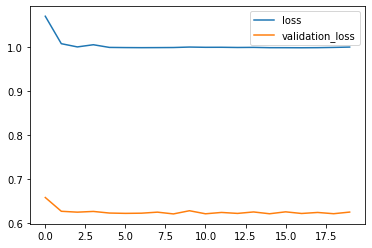

In [15]:
ARRNN_GRU = AR_RNN_model(all_data, arOrder=60, forecastSteps=15, coinID=4, dimRedMethod='Autoencoder', outputDim=15, trainStart = "25/05/2021", evalStart = "01/06/2021")

ARRNN_GRU.setARRNN_model(method = "Config", modelType = "GRU")

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 60, 1)            0         
 or)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 60)                0         
                                                                 
 dense_14 (Dense)            (None, 15)                915       
                                                                 
 reshape_2 (Reshape)         (None, 15, 1)             0         
                                                                 
Total params: 915
Trainable params: 915
Non-trainable params: 0
_____________________________________________________________

/opt/homebrew/Caskroom/miniforge/base/envs/DataSciPy_fast/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


7/7 [==============================] - 0s 2ms/step - loss: 0.2519 - val_loss: 0.2377
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3265 - val_loss: 0.0164
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0301 - val_loss: 0.0468
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0931 - val_loss: 0.0118
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0035
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 4.7261e-04
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 6.5601e-04 - val_loss: 8.3751e-04
Model: "Model_P1"
_________________________________________________________________
 Layer (type)                Output Shape         

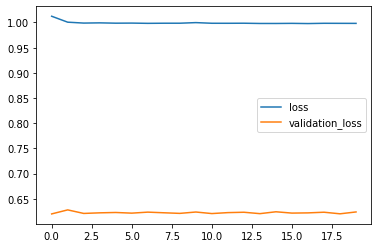

In [8]:
ARRNN_LSTM = AR_RNN_model(all_data, arOrder=60, forecastSteps=15, coinID=4, dimRedMethod='Autoencoder', outputDim=15, trainStart = "25/05/2021", evalStart = "01/06/2021")

ARRNN_LSTM.setARRNN_model(method = "Config", modelType = "LSTM")

GRU In-Sample  corr(Y, Y_hat): 0.0005381840743526939
GRU In-Sample  Bias(u): 0.018195754395954916
GRU In-Sample  Var(u): 0.9983813420228104
GRU In-Sample  MSE(u): 0.9987124275008483


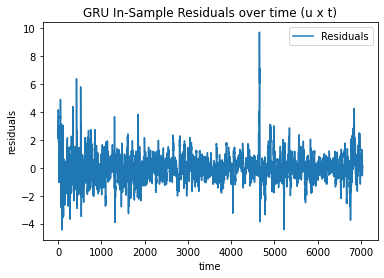

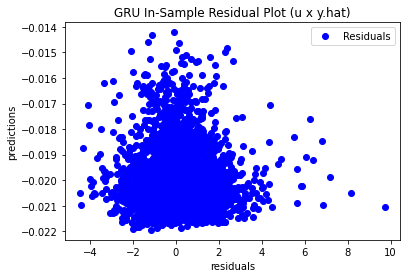

GRU Out-of-Sample  corr(Y, Y_hat): -0.00027615768750026187
GRU Out-of-Sample  Bias(u): 0.0668230686116168
GRU Out-of-Sample  Var(u): 0.6198323827170413
GRU Out-of-Sample  MSE(u): 0.6242977052157141


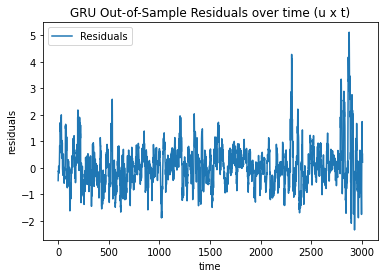

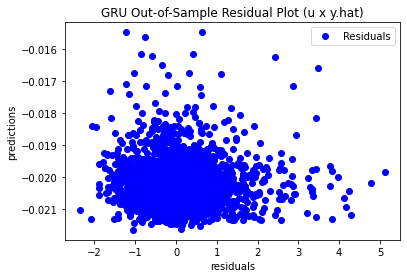

LSTM In-Sample  corr(Y, Y_hat): 0.03214829963924132
LSTM In-Sample  Bias(u): 0.017151728123885962
LSTM In-Sample  Var(u): 0.9978384597707266
LSTM In-Sample  MSE(u): 0.9981326415483623


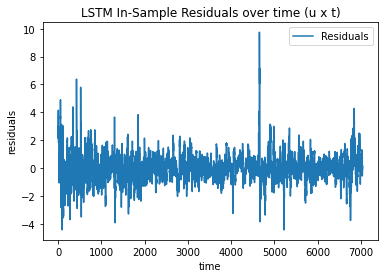

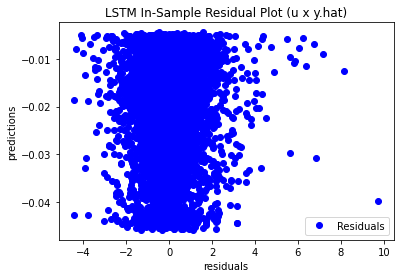

LSTM Out-of-Sample  corr(Y, Y_hat): 0.02482323039883708
LSTM Out-of-Sample  Bias(u): 0.06460363450894606
LSTM Out-of-Sample  Var(u): 0.6195874380217714
LSTM Out-of-Sample  MSE(u): 0.6237610676135369


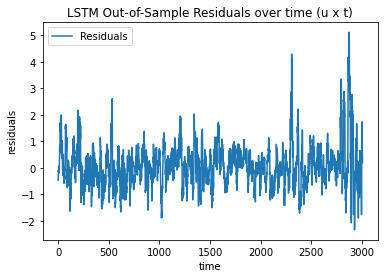

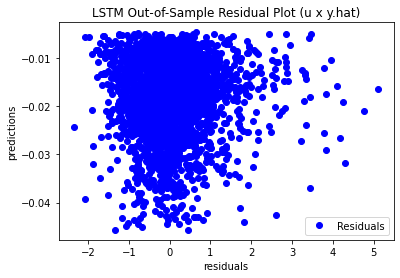

{'corr': 0.02482323039883708,
 'Bias': 0.06460363450894606,
 'Var': 0.6195874380217714,
 'MSE': 0.6237610676135369}

In [16]:
# GRU Model
Y_train_hat, Y_test_hat = ARRNN_GRU.getFittedData()[:2]
Y_train, Y_test = ARRNN_GRU.trainDF['Target'], ARRNN_GRU.testDF['Target']

performanceEval(Y_train, Y_train_hat, "GRU In-Sample ")
performanceEval(Y_test, Y_test_hat, "GRU Out-of-Sample ")

# LSTM Model
Y_train_hat, Y_test_hat = ARRNN_LSTM.getFittedData()[:2]
Y_train, Y_test = ARRNN_LSTM.trainDF['Target'], ARRNN_LSTM.testDF['Target']

performanceEval(Y_train, Y_train_hat, "LSTM In-Sample ")
performanceEval(Y_test, Y_test_hat, "LSTM Out-of-Sample ")

=> TODO Desicion for one model Type (has to be final)

##### Model Tuning

Trial 5 Complete [00h 01m 03s]
val_loss: 0.621131181716919

Best val_loss So Far: 0.620010495185852
Total elapsed time: 00h 05m 11s
INFO:tensorflow:Oracle triggered exit
Model: "Model_P1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 15, 240)           232320    
                                                                 
 dropout (Dropout)           (None, 15, 240)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                72240     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 304,62

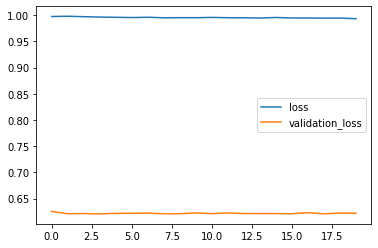

In-Sample  corr(Y, Y_hat): 0.07963897090854562
In-Sample  Bias(u): 0.002950870664391109
In-Sample  Var(u): 0.9928003250911056
In-Sample  MSE(u): 0.9928090327287836


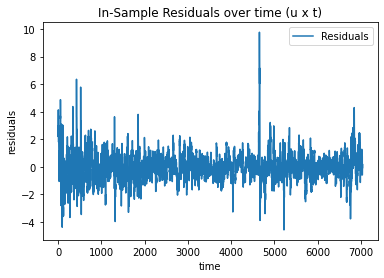

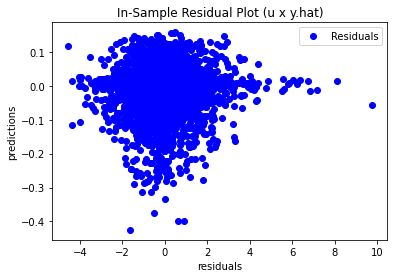

Out-of-Sample  corr(Y, Y_hat): 0.016605528150075398
Out-of-Sample  Bias(u): 0.04432820709566185
Out-of-Sample  Var(u): 0.6201386352844648
Out-of-Sample  MSE(u): 0.6221036252287807


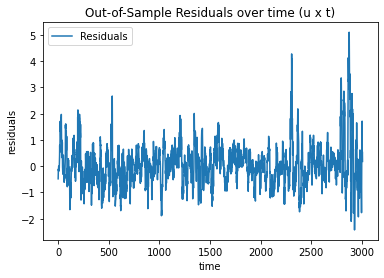

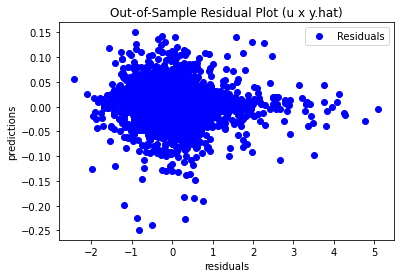

True Out-of-Sample  corr(Y, Y_hat): -0.0023300823549565397
True Out-of-Sample  Bias(u): 0.041433338429318345
True Out-of-Sample  Var(u): 0.9851674647784735
True Out-of-Sample  MSE(u): 0.9868841863118719


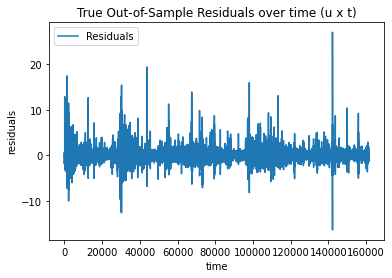

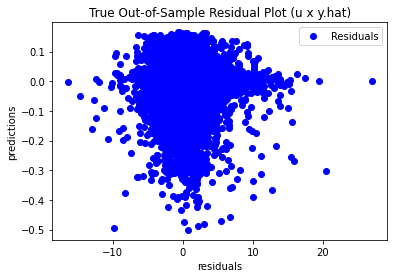

{'corr': -0.0023300823549565397,
 'Bias': 0.041433338429318345,
 'Var': 0.9851674647784735,
 'MSE': 0.9868841863118719}

In [18]:
# Model Estimation
ARRNN_mod = AR_RNN_model(all_data, arOrder=60, forecastSteps=15, coinID=4, dimRedMethod='Autoencoder', outputDim=15, trainStart = "25/05/2021", evalStart = "01/06/2021")

ARRNN_mod.setARRNN_model(method = "Tuner", modelType = "LSTM")

# Performance Evaluation
Y_train_hat, Y_test_hat, Y_eval_hat = ARRNN_mod.getFittedData()
Y_train, Y_test, Y_eval = ARRNN_mod.trainDF['Target'], ARRNN_mod.testDF['Target'], ARRNN_mod.evalDF['Target']

performanceEval(Y_train, Y_train_hat, "In-Sample ")
performanceEval(Y_test, Y_test_hat, "Out-of-Sample ")
performanceEval(Y_eval, Y_eval_hat, "True Out-of-Sample ")

The correlation results of the model vary heavily. In general the performance in-sample on the training dataset is slightly better than for the out-of-sample and true-out-of-sample datasets. Overall, however, they are very poor. This indicates that model cannot estimate, or rather find, the functional relationship between the price inputs and the target-variable. This can have multiple reasons. First indication could be the residual plots provided above. It seems like that there is variance clustering present in the residuals. This indicates that modeling approaches derived from GARCH could be more beneficial here. Secound (this might be more prominent in the residual plot for the test-dataset) there is persistence present in the residuals, meaning that positive residuals tend to follow on positive residuals and vice versa. Those effects could also be reduced by implementing a autoregressive error term (or moving-average lags known from AR(I)MA models). Additionally all the residual plots where the residuals are plottet against the predicted values show a "V"-shape. This implies that for higher values of (predicted) target variable the variance of the residuals increase.[TODO: Finish sentence] Another reason for the bad prediction performance could also be missing (input-) information or missing features. This possibility will be explored in more details with the second model in a later chapter.

In [12]:
ARRNN_mod.tuner.get_best_hyperparameters()[0].values

{'lr_priceModels': 0.0001,
 'lr': 0.01,
 'P1_L1_LSTMUnits': 240,
 'P1_L1_dropoutBool': False,
 'P1_L2_LSTMUnits': 60,
 'P16_L1_LSTMUnits': 240,
 'P16_L1_dropoutBool': False,
 'P16_L2_LSTMUnits': 120,
 'ARRNN_TargetFNN_RNNLayer': True,
 'ARRNN_TargetFNN_FL1Units': 60,
 'ARRNN_TargetFNN_FL1Activation': 'relu',
 'ARRNN_TargetFNN_FL2Units': 60,
 'ARRNN_TargetFNN_FL2Activation': 'relu'}

=> TODO: Discussion of hyperparameters

| Timewindow | Dataset | Autoencoder | Average |   None  |
|:----------:|:-------:|:-----------:|:-------:|:-------:|
| 1 week     | train   | 0,0778      | 0,0684  | 0,0451  |
|            | test    | 0,0123      | -0,0022 | 0,0325  |
|            | eval    | -0,0033     | 0,0145  | -0,0021 |
| 1 month    | train   | 0,0893      | 0,0693  | 0,0773  |
|            | test    | 0,0074      | 0,0497  | 0,0319  |
|            | eval    | 0,0464      | 0,0248  | 0,0501  |

*Correlation Results for coinID = 4, different dimension reduction methods and timewindows (or length of dataset)*

#### Coin: Etherium Classic

##### Model comparison

=> TODO: Introduction sentence

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 60, 1)            0         
 or)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 60)                0         
                                                                 
 dense_19 (Dense)            (None, 15)                915       
                                                                 
 reshape_2 (Reshape)         (None, 15, 1)             0         
                                                                 
Total params: 915
Trainable params: 915
Non-trainable params: 0
_____________________________________________________________

/opt/homebrew/Caskroom/miniforge/base/envs/DataSciPy_fast/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2782 - val_loss: 0.0628
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0394
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0054
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0153
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 1.1622e-04
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 3.1317e-06
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 5.4590e-04 - val_loss: 3.1132e-04
Model: "Model_P1"
_________________________________________________________________
 Layer (type)                Output

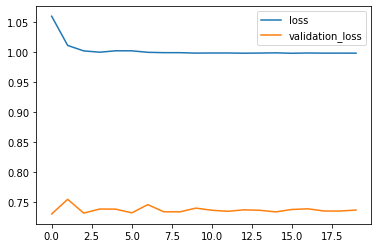

In [23]:
ARRNN_GRU = AR_RNN_model(all_data, arOrder=60, forecastSteps=15, coinID=6, dimRedMethod='Autoencoder', outputDim=15, trainStart = "25/05/2021", evalStart = "01/06/2021")

ARRNN_GRU.setARRNN_model(method = "Config", modelType = "GRU")

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 60, 1)            0         
 or)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 60)                0         
                                                                 
 dense_12 (Dense)            (None, 15)                915       
                                                                 
 reshape_1 (Reshape)         (None, 15, 1)             0         
                                                                 
Total params: 915
Trainable params: 915
Non-trainable params: 0
_____________________________________________________________

/opt/homebrew/Caskroom/miniforge/base/envs/DataSciPy_fast/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


7/7 [==============================] - 0s 9ms/step - loss: 1.6635 - val_loss: 0.0090
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3533 - val_loss: 0.2846
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2646 - val_loss: 7.6815e-04
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0662
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0010
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0162
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0166 - val_loss: 1.6444e-05
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 1.9730e-04
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 7.1220e-04
Model: "Model_P1"
________________

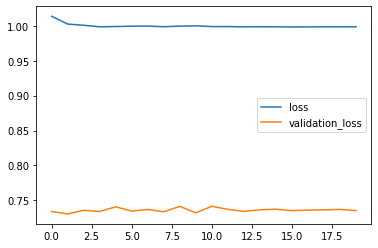

In [20]:
ARRNN_LSTM = AR_RNN_model(all_data, arOrder=60, forecastSteps=15, coinID=6, dimRedMethod='Autoencoder', outputDim=15, trainStart = "25/05/2021", evalStart = "01/06/2021")

ARRNN_LSTM.setARRNN_model(method = "Config", modelType = "LSTM")

GRU In-Sample  corr(Y, Y_hat): -0.003477129425322031
GRU In-Sample  Bias(u): 0.026978570900557754
GRU In-Sample  Var(u): 0.9982956865523187
GRU In-Sample  MSE(u): 0.9990235298401551


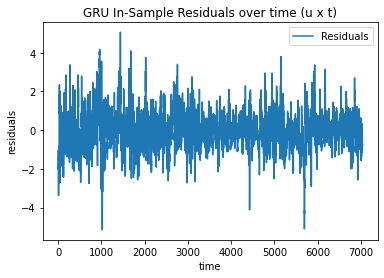

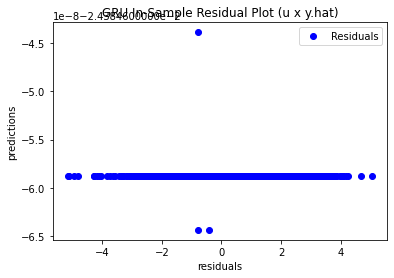

GRU Out-of-Sample  corr(Y, Y_hat): -0.0051166537717220704
GRU Out-of-Sample  Bias(u): 0.10193809604925087
GRU Out-of-Sample  Var(u): 0.7307285643578917
GRU Out-of-Sample  MSE(u): 0.741119939784038


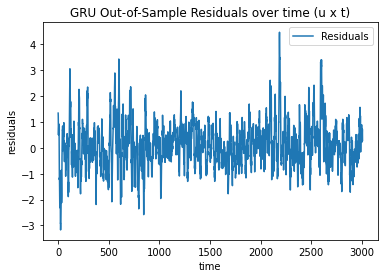

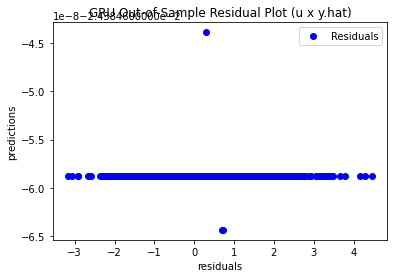

LSTM In-Sample  corr(Y, Y_hat): 0.004383135087121177
LSTM In-Sample  Bias(u): -0.006660884534408663
LSTM In-Sample  Var(u): 0.9982956865388909
LSTM In-Sample  MSE(u): 0.9983400539216716


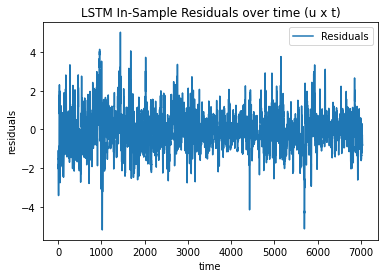

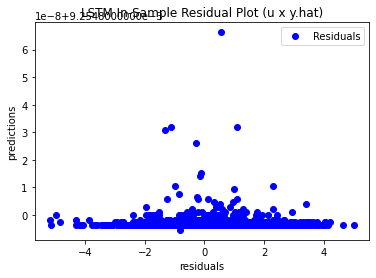

LSTM Out-of-Sample  corr(Y, Y_hat): 0.0025529097769772797
LSTM Out-of-Sample  Bias(u): 0.06829864072701643
LSTM Out-of-Sample  Var(u): 0.7307285643534633
LSTM Out-of-Sample  MSE(u): 0.7353932686786214


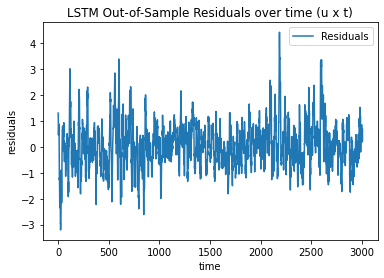

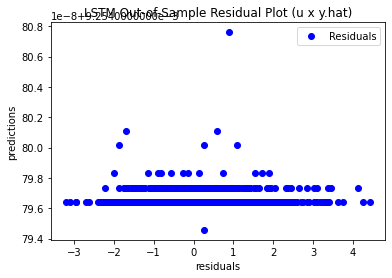

{'corr': 0.0025529097769772797,
 'Bias': 0.06829864072701643,
 'Var': 0.7307285643534633,
 'MSE': 0.7353932686786214}

In [22]:
# GRU Model
Y_train_hat, Y_test_hat = ARRNN_GRU.getFittedData()[:2]
Y_train, Y_test = ARRNN_GRU.trainDF['Target'], ARRNN_GRU.testDF['Target']

performanceEval(Y_train, Y_train_hat, "GRU In-Sample ")
performanceEval(Y_test, Y_test_hat, "GRU Out-of-Sample ")

# LSTM Model
Y_train_hat, Y_test_hat = ARRNN_LSTM.getFittedData()[:2]
Y_train, Y_test = ARRNN_LSTM.trainDF['Target'], ARRNN_LSTM.testDF['Target']

performanceEval(Y_train, Y_train_hat, "LSTM In-Sample ")
performanceEval(Y_test, Y_test_hat, "LSTM Out-of-Sample ")

=> TODO: Discussion which performs better

##### Model Tuning

In [ ]:
# Model Estimation
ARRNN_mod = AR_RNN_model(all_data, arOrder=60, forecastSteps=15, coinID=6, dimRedMethod='Autoencoder', outputDim=15, trainStart = "25/05/2021", evalStart = "01/06/2021")

ARRNN_mod.setARRNN_model(method = "Tuner", modelType = "LSTM")

# Performance Evaluation
Y_train_hat, Y_test_hat, Y_eval_hat = ARRNN_mod.getFittedData()
Y_train, Y_test, Y_eval = ARRNN_mod.trainDF['Target'], ARRNN_mod.testDF['Target'], ARRNN_mod.evalDF['Target']

performanceEval(Y_train, Y_train_hat, "In-Sample ")
performanceEval(Y_test, Y_test_hat, "Out-of-Sample ")
performanceEval(Y_eval, Y_eval_hat, "True Out-of-Sample ")

For the secound coin the same procedure is done as for the first coin to make the results comparable. The model is set up with ```arOrder = 60```, ```forecastSteps = 15``` and ```outputDim``` set to 15. The trainings window also stays the same as before.

| Timewindow | Dataset | Autoencoder | Average |   None  |
|:----------:|:-------:|:-----------:|:-------:|:-------:|
| 1 week     | train   | 0,0079      | 0,0572  | 0,0303  |
|            | test    | 0,0125      | -0,0265 | -0,0054 |
|            | eval    | -0,0070     | 0,0053  | 0,0045  |
| 1 month    | train   | -0,0008     | 0,0595  | 0,0134  |
|            | test    | nan         | -0,0101 | 0,0157  |
|            | eval    | nan         | 0,0075  | -0,0006 |

*Correlation Results for coinID = 6, different dimension reduction methods and timewindows (or length of dataset)*

## Indicator Model

### General Idea

=> TODO: Describe general Idea

### Model Class

=> TODO: Model beschreibung

### Results

#### Coin 1

 => TODO: Describe results for coin 1

#### Coin 2

=> TODO: Describe results for coin 1